#Cek GPU

In [1]:
!nvidia-smi

Fri May 16 06:59:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Install Library yang Dibutuhkan

In [2]:
!pip install segmentation_models_pytorch --quiet
!pip install albumentations --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.7 MB/s eta 0:00:00


segmentation_models_pytorch (SMP) = untuk DeepLabV3+</br>
albumentations = untuk augmentasi yang efisien.

#Dataset Setup

In [3]:
import os
print(os.listdir())

['.config', 'drive', 'sample_data']


In [6]:
import os
import re

# Fungsi bantu: natural sort
def natural_sort(l):
    return sorted(l, key=lambda x: [int(text) if text.isdigit() else text.lower()
                                    for text in re.split('([0-9]+)', x)])

# Path direktori
pardir = "/content/drive/MyDrive/colab_indra/ss/cwfid_daset_split/train/"

# List dan urutkan file
image_files = natural_sort(os.listdir(os.path.join(pardir, "images")))
ann_files = natural_sort(os.listdir(os.path.join(pardir, "annotations")))

# Tampilkan contoh 5 file pertama
print("📷 Images Folder:", image_files[:5])
print("📝 Annotation Folder:", ann_files[:5])

📷 Images Folder: ['002_image.png', '003_image.png', '004_image.png', '005_image.png', '007_image.png']
📝 Annotation Folder: ['002_annotation.png', '003_annotation.png', '004_annotation.png', '005_annotation.png', '007_annotation.png']


In [7]:
from PIL import Image
import numpy as np

mask_path = '/content/drive/MyDrive/colab_indra/ss/cwfid_daset_split/train/annotations/002_annotation.png'

mask = Image.open(mask_path)
mask_np = np.array(mask)

print("Mask shape:", mask_np.shape)
print("Unique pixel values (classes):", np.unique(mask_np))


Mask shape: (966, 1296, 3)
Unique pixel values (classes): [  0 255]


In [8]:
def convert_rgb_mask_to_label(mask_rgb):
    """
    Convert RGB mask (H, W, 3) → label mask (H, W)
    Black (0,0,0) → 0 (background)
    Green (0,255,0) → 1 (crop)
    Red (255,0,0) → 2 (weed)
    """
    label_mask = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)

    background = np.all(mask_rgb == [0, 0, 0], axis=-1)
    crop = np.all(mask_rgb == [0, 255, 0], axis=-1)
    weed = np.all(mask_rgb == [255, 0, 0], axis=-1)

    label_mask[background] = 0
    label_mask[crop] = 1
    label_mask[weed] = 2

    return label_mask


#Fungsi Visualisasi Gambar + Mask Asli

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [15]:
def visualize_image_and_ann(image_path, mask_path, class_colors=None):
    # Load image
    img = Image.open(image_path).convert("RGB")

    # Load dan convert mask ke label jika perlu
    mask_rgb = Image.open(mask_path).convert("RGB")
    mask_np = np.array(mask_rgb)

    # Convert RGB mask → label mask
    label_mask = convert_rgb_mask_to_label(mask_np)

    # Create color mask
    color_mask = np.zeros((label_mask.shape[0], label_mask.shape[1], 3), dtype=np.uint8)

    if class_colors is None:
        class_colors = {
            0: [0, 0, 0],        # Background → Black
            1: [0, 255, 0],      # Crop → Green
            2: [255, 0, 0]       # Weed → Red
        }

    for cls, color in class_colors.items():
        mask_idx = label_mask == cls
        color_mask[mask_idx, 0] = color[0]
        color_mask[mask_idx, 1] = color[1]
        color_mask[mask_idx, 2] = color[2]

    # Plot hasil
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(color_mask)
    plt.title('Ground Truth Mask (Colored)')

    plt.axis('off')
    plt.show()


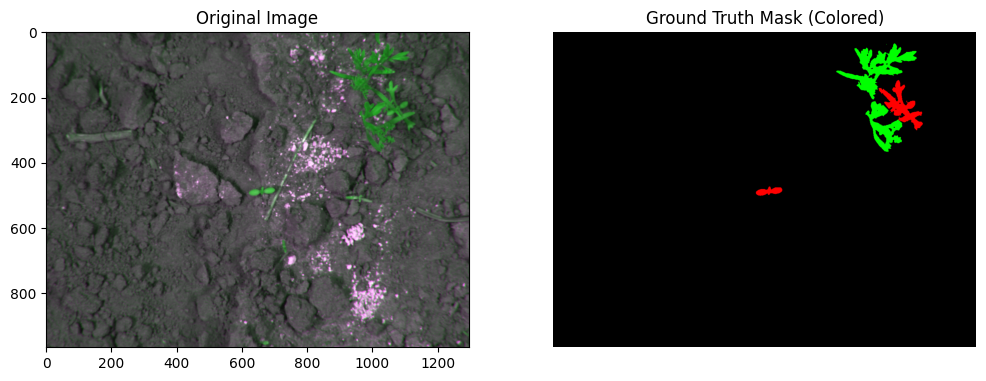

In [17]:
# Path direktori
pardir = "/content/drive/MyDrive/colab_indra/ss/cwfid_daset_split/train/"
image_dir = os.path.join(pardir, "images")
ann_dir = os.path.join(pardir, "annotations")

# Ambil list dan urutkan
image_files = natural_sort(os.listdir(image_dir))

# Pilih random file
import random
chosen_file = random.choice(image_files)
ann_file_ex = chosen_file.replace('image', 'annotation')  # atau 'mask' jika pakai mask folder

# Bangun path lengkap
image_path = os.path.join(image_dir, chosen_file)
ann_path = os.path.join(ann_dir, ann_file_ex)

# Tampilkan
visualize_image_and_ann(image_path, ann_path)


In [18]:
print(np.unique(mask_np))

[  0 255]


#Patching On-the-Fly Dataset (Dataloader)

In [19]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch


In [20]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CWFIDPatchDataset(Dataset):
    def __init__(self, image_dir, mask_dir, patch_size=512, stride=256, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        # ✅ Filter hanya file gambar yang diinginkan
        valid_ext = ['.png', '.jpg', '.jpeg']

        self.image_paths = sorted([
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if os.path.splitext(f)[1].lower() in valid_ext
        ])

        self.mask_paths = sorted([
            os.path.join(mask_dir, f)
            for f in os.listdir(mask_dir)
            if os.path.splitext(f)[1].lower() in valid_ext
        ])

        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.patches = self.create_patch_index()

    def create_patch_index(self):
        patch_list = []
        for idx, img_path in enumerate(self.image_paths):
            img = Image.open(img_path)
            w, h = img.size
            for y in range(0, h - self.patch_size + 1, self.stride):
                for x in range(0, w - self.patch_size + 1, self.stride):
                    patch_list.append((idx, x, y))
        return patch_list

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, index):
        idx, x, y = self.patches[index]

        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("RGB")  # convert RGB biar aman ke label mask

        img_patch = img.crop((x, y, x + self.patch_size, y + self.patch_size))
        mask_patch = mask.crop((x, y, x + self.patch_size, y + self.patch_size))

        # Convert mask ke label di sini (jika perlu), atau lakukan di transform
        mask_patch = np.array(mask_patch)
        mask_patch = convert_rgb_mask_to_label(mask_patch)

        if self.transform:
            augmented = self.transform(image=np.array(img_patch), mask=mask_patch)
            img_patch = augmented['image']
            mask_patch = augmented['mask']

        return img_patch, torch.as_tensor(mask_patch, dtype=torch.long)


#Transformasi & Augmentasi (Albumentations)

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomCrop(512, 512, p=1.0),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(transpose_mask=True)
    ])


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


#Fungsi buat cek loader & augmentasi:

In [22]:
def visualize_dataset_sample(dataset, index=0, class_colors=None):
    # Ambil sample dari dataset
    img_patch, mask_patch = dataset[index]

    # Convert Tensor ke numpy array
    img_np = img_patch.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    img_np = (img_np * 0.5 + 0.5)  # Unnormalize
    img_np = np.clip(img_np, 0, 1)

    # Convert mask ke numpy array
    mask_np = mask_patch.cpu().numpy()

    # FIX: Mask RGB → Label mask
    if mask_np.ndim == 3 and mask_np.shape[2] == 3:
        print("Converting RGB mask to label mask...")
        mask_np = convert_rgb_mask_to_label(mask_np)

    # Buat canvas warna mask
    color_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    if class_colors is None:
        class_colors = {
            0: [0, 0, 0],        # Background → Black
            1: [0, 255, 0],      # Crop → Green
            2: [255, 0, 0]       # Weed → Red
        }

    for cls, color in class_colors.items():
        mask_idx = mask_np == cls
        color_mask[mask_idx] = color

    # Overlay mask di atas gambar
    def overlay_mask_on_image(image, mask, alpha=0.4):
        return np.clip((1 - alpha) * image + alpha * (mask / 255.0), 0, 1)

    overlay = overlay_mask_on_image(img_np, color_mask)

    # Plot semua hasil
    plt.figure(figsize=(24, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title(f'Patch Image #{index}')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title(f'Label Mask #{index}')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(color_mask)
    plt.title(f'Colored Mask #{index}')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title(f'Overlay Patch + Mask #{index}')
    plt.axis('off')

    plt.show()


#Load Dataset

In [23]:
# Sesuaikan path folder
image_dir = image_dir
mask_dir = ann_dir

In [24]:
# Buat dataset patch on-the-fly
dataset = CWFIDPatchDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    patch_size=512,
    stride=256,
    transform=train_transform  # augmentasi dasar
)

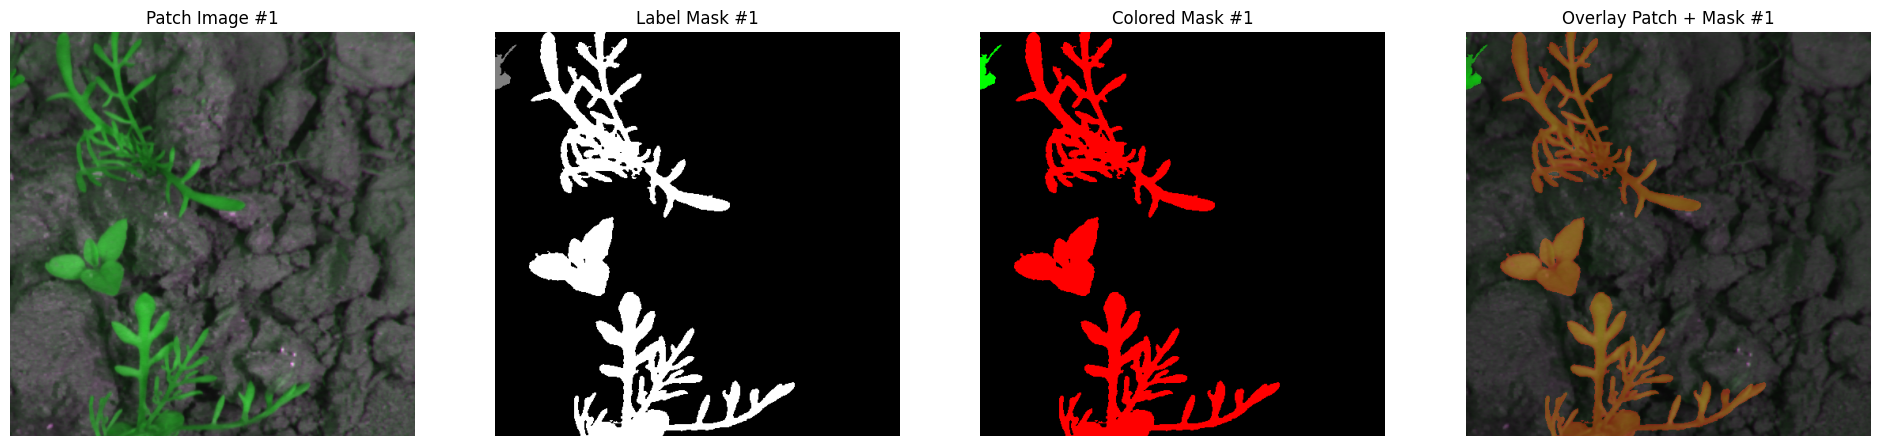

In [25]:
# Dari dataset patch loader (on-the-fly)
visualize_dataset_sample(dataset, index=1)


#Dataset Split

In [26]:
import numpy as np
from torch.utils.data import Subset

def split_dataset(dataset, train_ratio=0.8, val_ratio=0.2, shuffle=True):
    # FIX: Handle floating point precision
    assert np.isclose(train_ratio + val_ratio, 1.0), "Train + Val ratio must be 1.0"

    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    if shuffle:
        np.random.shuffle(indices)

    train_end = int(train_ratio * dataset_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    print(f"Total Patches: {dataset_size}")
    print(f"Train Set    : {len(train_dataset)} patches ({train_ratio*100:.1f}%)")
    print(f"Valid Set    : {len(val_dataset)} patches ({val_ratio*100:.1f}%)")

    return train_dataset, val_dataset


#Setup DeepLabV3+ (Guru Model) dengan Mixed Precision

In [27]:
import segmentation_models_pytorch as smp
import torch.nn as nn

# DeepLabV3+ dengan EfficientNet-B4 backbone
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
).cuda()

# Loss Function
dice_loss = smp.losses.DiceLoss(mode='multiclass')
focal_loss = smp.losses.FocalLoss(mode='multiclass')

def total_loss(pred, target):
    return dice_loss(pred, target) + focal_loss(pred, target)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

In [28]:
!pip install torchinfo


In [29]:
from torchinfo import summary

# Pastikan model di GPU / CPU
model = model.cuda()  # atau .cpu() sesuai device

# Tampilkan summary, contoh input shape: (batch_size, channels, height, width)
summary(model, input_size=(1, 3, 512, 512))


Layer (type:depth-idx)                                  Output Shape              Param #
DeepLabV3Plus                                           [1, 3, 512, 512]          --
├─EfficientNetEncoder: 1-1                              [1, 3, 512, 512]          806,400
│    └─Conv2dStaticSamePadding: 2-1                     [1, 48, 256, 256]         1,296
│    │    └─ZeroPad2d: 3-1                              [1, 3, 513, 513]          --
│    └─BatchNorm2d: 2-2                                 [1, 48, 256, 256]         96
│    └─SiLU: 2-3                                        [1, 48, 256, 256]         --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [1, 24, 256, 256]         2,940
│    │    └─MBConvBlock: 3-3                            [1, 24, 256, 256]         1,206
│    │    └─MBConvBlock: 3-4                            [1, 32, 128, 128]         11,878
│    │    └─MBConvBlock: 3-5              

In [31]:
model_summary = summary(model, input_size=(1, 3, 512, 512))
with open('/content/drive/MyDrive/colab_indra/ss/cwfid_new_V2/Deeplabv3plus_model_summary.txt', 'w') as f:
    f.write(str(model_summary))


#Mixed Precision Training Loop

In [32]:
import segmentation_models_pytorch as smp
import torch.nn as nn

# DeepLabV3+ dengan EfficientNet-B4 backbone
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
).cuda()

# Loss Function
dice_loss = smp.losses.DiceLoss(mode='multiclass')
focal_loss = smp.losses.FocalLoss(mode='multiclass')

def total_loss(pred, target):
    return dice_loss(pred, target) + focal_loss(pred, target)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


#Fungsi Evaluasi

In [33]:
from sklearn.metrics import confusion_matrix
import numpy as np

def calculate_metrics(outputs, masks, num_classes=3):
    """
    outputs: logits dari model, shape (B, C, H, W)
    masks: ground truth label, shape (B, H, W)
    """
    # Ambil prediksi kelas per pixel
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    masks = masks.cpu().numpy()

    iou_list = []
    dice_list = []
    pixel_acc_list = []

    for cls in range(num_classes):
        tp = np.logical_and(preds == cls, masks == cls).sum()
        fp = np.logical_and(preds == cls, masks != cls).sum()
        fn = np.logical_and(preds != cls, masks == cls).sum()

        # IoU
        iou = tp / (tp + fp + fn + 1e-7)
        iou_list.append(iou)

        # Dice
        dice = 2 * tp / (2 * tp + fp + fn + 1e-7)
        dice_list.append(dice)

    # Pixel Accuracy
    pixel_acc = (preds == masks).sum() / np.prod(masks.shape)
    pixel_acc_list.append(pixel_acc)

    return np.mean(iou_list), np.mean(dice_list), np.mean(pixel_acc_list)


#Loop Evaluasi

In [34]:
def validate_epoch(loader, model):
    model.eval()
    iou_total, dice_total, acc_total = 0.0, 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.cuda(), masks.cuda()

            with autocast():
                outputs = model(imgs)

            iou, dice, acc = calculate_metrics(outputs, masks)
            iou_total += iou
            dice_total += dice
            acc_total += acc

    num_batches = len(loader)
    return iou_total / num_batches, dice_total / num_batches, acc_total / num_batches


 #EarlyStopping & ReduceLROnPlateau

In [35]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = -np.inf
        self.early_stop = False

    def __call__(self, val_iou):  # ← monitor val_iou
        if val_iou - self.best_score > self.min_delta:
            self.best_score = val_iou
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [36]:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

In [37]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',           # maximize val_iou
    factor=0.5,           # Turunin LR jadi setengah
    patience=20,          # Kalau 10 epoch val_iou ga naik, LR diturunin
    threshold=1e-4,       # Toleransi perubahan (agar ga terlalu reaktif)
    min_lr=1e-6,          # Minimum LR biar ga 0
    #verbose=True          # Print info kalau LR turun
)


#Fungsi Evaluasi Metrics + Confusion Matrix (Training dan Validation)

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_metrics(model, loader, dataset_name='Dataset', num_classes=3, class_names=None):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.cuda()
            masks = masks.cuda()

            with autocast():
                outputs = model(imgs)

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    # Flatten semua batch jadi 1 array
    all_preds = np.concatenate(all_preds).flatten()
    all_masks = np.concatenate(all_masks).flatten()

    # Hitung metrics
    precision = precision_score(all_masks, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_masks, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_masks, all_preds, average='macro', zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    # Print hasil metrics
    print(f"📊 {dataset_name} Metrics:")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro):    {recall:.4f}")
    print(f"F1-Score (macro):  {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Optional: Plot Confusion Matrix
    if class_names:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{dataset_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    return precision, recall, f1, cm


# Split Dataset train/val/test

In [40]:
# Split ke train/val/test
train_dataset, val_dataset = split_dataset(dataset, 0.8, 0.2)

# Loader train
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Loader validasi
val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


Total Patches: 384
Train Set    : 307 patches (80.0%)
Valid Set    : 77 patches (20.0%)


#Training + Validation + EarlyStopping + Save Model Guru Terbaik

In [41]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_epoch(loader, model, optimizer):
    model.train()
    running_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.cuda()
        masks = masks.cuda()

        optimizer.zero_grad()

        # Mixed Precision Training
        with autocast():
            outputs = model(imgs)

            # Hitung loss → sesuaikan dengan loss yang kamu pakai
            loss = total_loss(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    return running_loss / len(loader)


<ipython-input-41-27281aed4cbc>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [42]:
def validate_epoch(loader, model):
    model.eval()
    iou_total, dice_total, acc_total = 0.0, 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.cuda()
            masks = masks.cuda()

            with autocast():
                outputs = model(imgs)

            iou, dice, acc = calculate_metrics(outputs, masks)
            iou_total += iou
            dice_total += dice
            acc_total += acc

    num_batches = len(loader)
    return iou_total / num_batches, dice_total / num_batches, acc_total / num_batches


In [43]:
# Inisialisasi history buat logging metrics
history = {
    "train_loss": [],
    "val_iou": [],
    "val_dice": [],
    "val_acc": []
}

# Training loop
epochs = 1000
best_val_iou = 0.0
best_val_dice= 0.0
early_stopper = EarlyStopping(patience=60, min_delta=1e-4)

for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]")

    # TRAINING
    train_loss = train_epoch(train_loader, model, optimizer)

    # VALIDATION
    val_iou, val_dice, val_acc = validate_epoch(val_loader, model)

    # Scheduler update
    scheduler.step(val_iou)

    # Logging learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.8f}")

    # Logging
    history["train_loss"].append(train_loss)
    history["val_iou"].append(val_iou)
    history["val_dice"].append(val_dice)
    history["val_acc"].append(val_acc)
    history.setdefault("lr", []).append(current_lr)

    # Print hasil
    print(f"Train Loss: {train_loss:.4f} | Val IoU: {val_iou:.4f} | Val Dice: {val_dice:.4f} | Val Acc: {val_acc:.4f}")

    # Save guru model terbaik
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), 'best_guru_model_iou.pth')
        print("✅ Model Guru Terbaik Disimpan! (IoU Dice improved)")

    # Save best model berdasar val_dice (optional)
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), 'best_guru_model_dice.pth')
        print("✅ Guru Model disimpan! (Dice improved)")


    # Early stopping check
    early_stopper(val_iou)
    if early_stopper.early_stop:
        print("⏹️ Early stopping triggered!")
        break



Epoch [1/1000]


<ipython-input-41-27281aed4cbc>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-42-9a495bce8f18>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Learning Rate: 0.00010000
Train Loss: 0.9932 | Val IoU: 0.5975 | Val Dice: 0.7045 | Val Acc: 0.9390
✅ Model Guru Terbaik Disimpan! (IoU Dice improved)
✅ Guru Model disimpan! (Dice improved)
Epoch [2/1000]
Learning Rate: 0.00010000
Train Loss: 0.6010 | Val IoU: 0.7024 | Val Dice: 0.7944 | Val Acc: 0.9642
✅ Model Guru Terbaik Disimpan! (IoU Dice improved)
✅ Guru Model disimpan! (Dice improved)
Epoch [3/1000]
Learning Rate: 0.00010000
Train Loss: 0.4137 | Val IoU: 0.7542 | Val Dice: 0.8333 | Val Acc: 0.9742
✅ Model Guru Terbaik Disimpan! (IoU Dice improved)
✅ Guru Model disimpan! (Dice improved)
Epoch [4/1000]
Learning Rate: 0.00010000
Train Loss: 0.3005 | Val IoU: 0.8070 | Val Dice: 0.8792 | Val Acc: 0.9782
✅ Model Guru Terbaik Disimpan! (IoU Dice improved)
✅ Guru Model disimpan! (Dice improved)
Epoch [5/1000]
Learning Rate: 0.00010000
Train Loss: 0.2362 | Val IoU: 0.8244 | Val Dice: 0.8916 | Val Acc: 0.9793
✅ Model Guru Terbaik Disimpan! (IoU Dice improved)
✅ Guru Model disimpan! (Dice 

In [44]:
import os
save_path = '/content/drive/MyDrive/colab_indra/ss/cwfid_new_V2'


os.makedirs(save_path, exist_ok=True)
# Path file
best_model_path = os.path.join(save_path, 'best_guru_model.pth')

# Save best model guru
torch.save(model.state_dict(), best_model_path)
print(f"✅ Model Guru Terbaik Disimpan di: {best_model_path}")

✅ Model Guru Terbaik Disimpan di: /content/drive/MyDrive/colab_indra/ss/cwfid_new_V2/best_guru_model.pth


In [48]:
import os
import json
import pandas as pd

# Path penyimpanan di Google Drive
save_path = '/content/drive/MyDrive/colab_indra/ss/cwfid_new_V2'

# Pastikan folder ada
os.makedirs(save_path, exist_ok=True)

# Save JSON
history_filename_json = os.path.join(save_path, 'guru_training_history.json')
with open(history_filename_json, 'w') as f:
    json.dump(history, f)
print(f"✅ History JSON saved to {history_filename_json}")

# Save CSV
df_history = pd.DataFrame(history)
history_filename_csv = os.path.join(save_path, 'guru_training_history.csv')
df_history.to_csv(history_filename_csv, index=False)
print(f"✅ History CSV saved to {history_filename_csv}")


✅ History JSON saved to /content/drive/MyDrive/colab_indra/ss/cwfid_new_V2/guru_training_history.json
✅ History CSV saved to /content/drive/MyDrive/colab_indra/ss/cwfid_new_V2/guru_training_history.csv


In [45]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(18, 5))

    # Train Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], 'b', label='Train Loss')
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Validation IoU
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["val_iou"], 'g', label='Validation IoU')
    plt.title('Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Validation Dice & Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["val_dice"], 'r', label='Validation Dice')
    plt.plot(epochs, history["val_acc"], 'm', label='Validation Pixel Acc')
    plt.title('Validation Dice & Pixel Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.show()


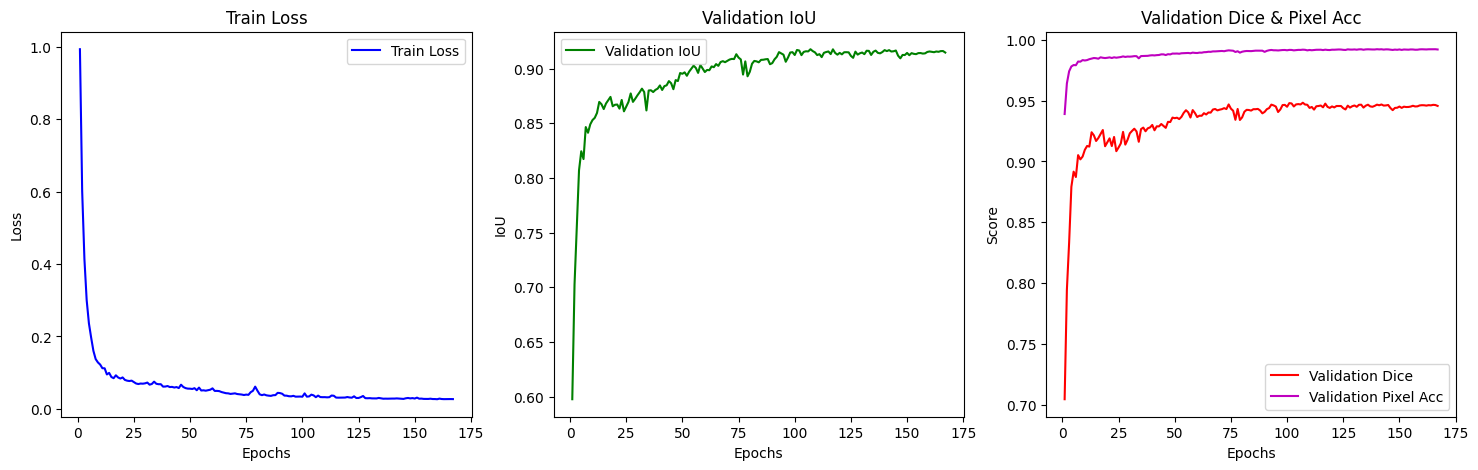

In [46]:
plot_training_history(history)


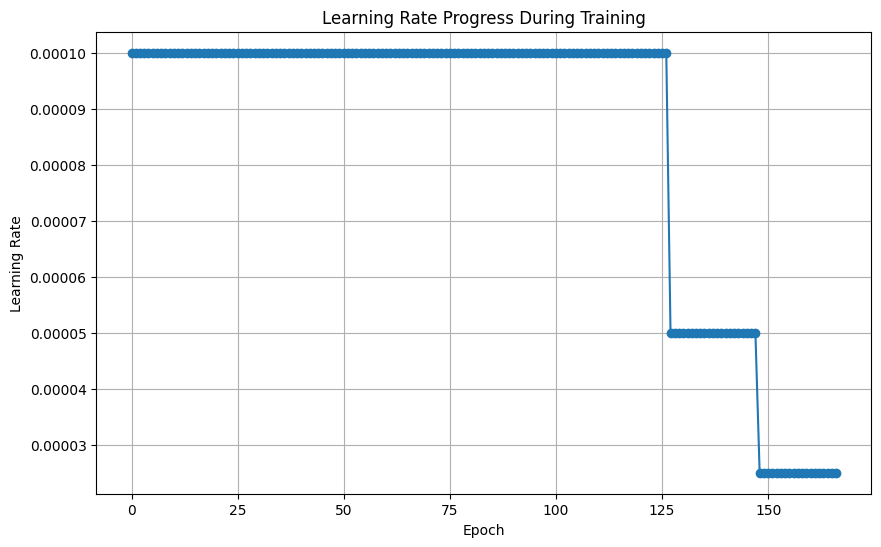

In [47]:
import matplotlib.pyplot as plt

# Plot Learning Rate vs Epoch
plt.figure(figsize=(10, 6))
plt.plot(history["lr"], marker='o')
plt.title("Learning Rate Progress During Training")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


#Dataset Test

In [49]:
model.load_state_dict(torch.load('/content/drive/MyDrive/colab_indra/ss/cwfid_new_V2/best_guru_model.pth'))
model.cuda()

DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_paddin

##On patch test

In [151]:
!pip install ttach


In [152]:
import ttach as tta
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_with_tta(model, dataloader, class_names, device='cuda'):
    model.eval()

    # 🔁 Bungkus model dengan TTA
    tta_transforms = tta.Compose([
        tta.HorizontalFlip(),
        tta.Multiply(factors=[0.9, 1.0, 1.1])
    ])
    tta_model = tta.SegmentationTTAWrapper(model, tta_transforms)

    total_cm = np.zeros((len(class_names), len(class_names)), dtype=np.int64)

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating with TTA"):
            images = images.to(device)
            targets = targets.to(device)

            outputs = tta_model(images)
            preds = torch.argmax(outputs, dim=1)

            # Hitung confusion matrix per batch
            for t, p in zip(targets.view(-1), preds.view(-1)):
                total_cm[t.item(), p.item()] += 1

    # Hitung metrik dari confusion matrix
    ious = []
    dices = []
    precisions = []
    recalls = []

    for i in range(len(class_names)):
        TP = total_cm[i, i]
        FP = total_cm[:, i].sum() - TP
        FN = total_cm[i, :].sum() - TP
        TN = total_cm.sum() - (TP + FP + FN)

        iou = TP / (TP + FP + FN + 1e-6)
        dice = (2 * TP) / (2 * TP + FP + FN + 1e-6)
        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)

        ious.append(iou)
        dices.append(dice)
        precisions.append(precision)
        recalls.append(recall)

    acc = np.trace(total_cm) / np.sum(total_cm)

    print(f"📊 Evaluation with TTA:")
    print(f"Overall Accuracy : {acc:.4f}")
    print(f"Precision (macro): {np.mean(precisions):.4f}")
    print(f"Recall (macro)   : {np.mean(recalls):.4f}")
    print(f"F1-Score (macro) : {np.mean(dices):.4f}")
    print(f"mIoU             : {np.mean(ious):.4f}")
    print(f"mDice            : {np.mean(dices):.4f}")


In [153]:
import ttach as tta

transforms = tta.Compose([
    tta.HorizontalFlip(),
    tta.Multiply(factors=[0.9, 1, 1.1]),  # brightness variation
])

tta_model = tta.SegmentationTTAWrapper(model, transforms)


In [154]:
transform_test = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

In [155]:
pardir_test = "/content/drive/MyDrive/colab_indra/ss/cwfid_daset_split/test/"
imagetest_dir = os.path.join(pardir_test, "images")
anntest_dir = os.path.join(pardir_test, "annotations")

# Buat dataset patch on-the-fly
dataset_test = CWFIDPatchDataset(
    image_dir=imagetest_dir,
    mask_dir=anntest_dir,
    patch_size=512,
    stride=256,
    transform=transform_test  # augmentasi dasar
)

In [156]:
test_loader = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [157]:
evaluate_with_tta(model, test_loader, class_names=["BG", "Crop", "Weed"], device='cuda')

Evaluating with TTA: 100%|██████████| 96/96 [12:14<00:00,  7.65s/it]

📊 Evaluation with TTA:
Overall Accuracy : 0.9179
Precision (macro): 0.5887
Recall (macro)   : 0.6359
F1-Score (macro) : 0.5551
mIoU             : 0.4793
mDice            : 0.5551


#Convensional test

In [149]:
def evaluate_all_metrics(model, loader, class_names=None, num_classes=3, dataset_name="Dataset", device='cuda'):
    model.eval()
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs_raw = model(imgs)
            outputs = outputs_raw[0] if isinstance(outputs_raw, (tuple, list)) else outputs_raw
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    all_preds = np.concatenate(all_preds).flatten()
    all_masks = np.concatenate(all_masks).flatten()

    precision_macro = precision_score(all_masks, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_masks, all_preds, average='macro', zero_division=0)
    f1_macro = f1_score(all_masks, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    precision = precision_score(all_masks, all_preds, average=None, zero_division=0)
    recall = recall_score(all_masks, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_masks, all_preds, average=None, zero_division=0)

    ious = []
    dices = []
    for cls in range(num_classes):
        tp = np.logical_and(all_preds == cls, all_masks == cls).sum()
        fp = np.logical_and(all_preds == cls, all_masks != cls).sum()
        fn = np.logical_and(all_preds != cls, all_masks == cls).sum()
        iou = tp / (tp + fp + fn + 1e-7)
        dice = 2 * tp / (2 * tp + fp + fn + 1e-7)
        ious.append(iou)
        dices.append(dice)

    pixel_acc = (all_preds == all_masks).sum() / len(all_masks)
    miou = np.mean(ious)
    mdice = np.mean(dices)

    print(f"\n📊 {dataset_name} Evaluation Summary")
    print(f"Overall Accuracy : {pixel_acc:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Recall (macro)   : {recall_macro:.4f}")
    print(f"F1-Score (macro) : {f1_macro:.4f}")
    print(f"mIoU             : {miou:.4f}")
    print(f"mDice            : {mdice:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    for i in range(num_classes):
        cname = class_names[i] if class_names else f"Class {i}"
        print(f"\n📌 {cname}")
        print(f"  IoU      : {ious[i]:.4f}")
        print(f"  Dice     : {dices[i]:.4f}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall   : {recall[i]:.4f}")
        print(f"  F1-Score : {f1[i]:.4f}")


In [150]:
#patch mode
evaluate_all_metrics(model, test_loader, class_names=["BG", "Crop", "Weed"], dataset_name="Test Set", device='cuda')


📊 Test Set Evaluation Summary
Overall Accuracy : 0.9815
Precision (macro): 0.9093
Recall (macro)   : 0.9056
F1-Score (macro) : 0.9043
mIoU             : 0.8328
mDice            : 0.9043
Confusion Matrix:
[[22551416    54533   191121]
 [   37625   512981   121938]
 [   52050     7379  1636781]]

📌 BG
  IoU      : 0.9853
  Dice     : 0.9926
  Precision: 0.9960
  Recall   : 0.9892
  F1-Score : 0.9926

📌 Crop
  IoU      : 0.6985
  Dice     : 0.8225
  Precision: 0.8923
  Recall   : 0.7627
  F1-Score : 0.8225

📌 Weed
  IoU      : 0.8146
  Dice     : 0.8978
  Precision: 0.8394
  Recall   : 0.9650
  F1-Score : 0.8978


##without patch

In [100]:
#without patch
class OriDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_filename = self.image_files[idx].replace("image", "annotation")
        mask_path = os.path.join(self.mask_dir, mask_filename)


        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale

        mask_np = np.array(mask).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=np.array(img), mask=mask_np)
            img = augmented["image"]
            mask = augmented["mask"]

        return img, torch.as_tensor(mask, dtype=torch.long)


In [107]:
import albumentations as A
from albumentations.pytorch import ToTensorV2



In [108]:
split_base = "/content/drive/MyDrive/colab_indra/ss/cwfid_daset_split/"


In [112]:
test_datasetload = OriDataset(
    image_dir=os.path.join(split_base, "test", "images"),
    mask_dir=os.path.join(split_base, "test", "annotations"),
    transform=train_transform
)


In [113]:
test_oriloader = DataLoader(test_datasetload, batch_size=4, shuffle=False)

In [114]:
evaluate_all_metrics(model, test_oriloader, class_names=["BG", "Crop", "Weed"], dataset_name="Test Set", device='cuda')


📊 Test Set Evaluation Summary
Overall Accuracy : 0.8559
Precision (macro): 0.1986
Recall (macro)   : 0.1967
F1-Score (macro) : 0.1976
mIoU             : 0.3254
mDice            : 0.3293
Confusion Matrix:
[[2692288    7525   38300]
 [      0       0       0]
 [      0       0       0]]

📌 BG
  IoU      : 0.9763
  Dice     : 0.9880
  Precision: 0.9928
  Recall   : 0.9833
  F1-Score : 0.9880

📌 Crop
  IoU      : 0.0000
  Dice     : 0.0000
  Precision: 0.0000
  Recall   : 0.0000
  F1-Score : 0.0000

📌 Weed
  IoU      : 0.0000
  Dice     : 0.0000
  Precision: 0.0000
  Recall   : 0.0000
  F1-Score : 0.0000


# Fungsi Evaluasi Klasik

In [ ]:
# Load model guru terbaik
#model.load_state_dict(torch.load('best_guru_model.pth'))
model.cuda()

# Nama kelas (optional buat plot)
class_names = ['Background', 'Crop', 'Weed']

# Evaluasi di training data
train_precision, train_recall, train_f1, train_cm = evaluate_metrics(
    model, train_loader, dataset_name='Training', class_names=class_names
)

# Evaluasi di validation data
val_precision, val_recall, val_f1, val_cm = evaluate_metrics(
    model, val_loader, dataset_name='Validation', class_names=class_names
)

# Evaluasi di test data
test_precision, test_recall, test_f1, test_cm = evaluate_metrics(
    model, test_loader,
    dataset_name='Test',
    class_names=class_names
)




```
📊 Training Metrics:
Precision (macro): 0.95
Recall (macro):    0.93
F1-Score (macro):  0.94
Confusion Matrix:
[[50000   100   200]
 [  150 12000   300]
 [  250   400  8000]]

📊 Validation Metrics:
Precision (macro): 0.88
Recall (macro):    0.85
F1-Score (macro):  0.86
Confusion Matrix:
[[49000   200   500]
 [  300 11000   500]
 [  400   800  7000]]
```




#Evaluasi Per Class

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_per_class_metrics(model, loader, class_names=None, num_classes=3):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.cuda()
            masks = masks.cuda()

            with torch.amp.autocast('cuda'):
                outputs = model(imgs)

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy().flatten())
            all_masks.append(masks.cpu().numpy().flatten())

    # Gabungkan semua batch
    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)

    # Confusion Matrix (raw count)
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    # Confusion Matrix (percent per row/class)
    cm_percent = cm.astype(np.float64)
    cm_percent = cm_percent / cm_percent.sum(axis=1, keepdims=True) * 100
    cm_percent = np.round(cm_percent, 2)

    # Precision, Recall, F1-score per kelas
    precision = precision_score(all_masks, all_preds, labels=list(range(num_classes)), average=None, zero_division=0)
    recall = recall_score(all_masks, all_preds, labels=list(range(num_classes)), average=None, zero_division=0)
    f1 = f1_score(all_masks, all_preds, labels=list(range(num_classes)), average=None, zero_division=0)

    # IoU per kelas
    iou_per_class = []
    for cls in range(num_classes):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-7)
        iou_per_class.append(iou)

    # Print Metrics Per Class
    print("Class-wise Metrics:\n")
    for cls in range(num_classes):
        class_name = class_names[cls] if class_names else f"Class {cls}"
        print(f"📌 {class_name}")
        print(f"Precision: {precision[cls]:.4f}")
        print(f"Recall   : {recall[cls]:.4f}")
        print(f"F1-Score : {f1[cls]:.4f}")
        print(f"IoU      : {iou_per_class[cls]:.4f}\n")

    # Plot Confusion Matrix (Percent)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names if class_names else range(num_classes),
                yticklabels=class_names if class_names else range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (%) per Class')
    plt.show()

    return precision, recall, f1, iou_per_class, cm_percent


In [ ]:
class_names = ['Background', 'Crop', 'Weed']
evaluate_per_class_metrics(model, train_loader, class_names=class_names)
evaluate_per_class_metrics(model, val_loader, class_names=class_names)
evaluate_per_class_metrics(model, test_loader, class_names=class_names)


#Inferensi Full Image Dataset Asli

In [ ]:
# Load best guru model
model.load_state_dict(torch.load('/content/drive/MyDrive/colab_indra/ss/cwfid_new/02/best_guru_model.pth'))
model.cuda()
model.eval()



In [ ]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


In [ ]:
def infer_full_image(image_path, model, patch_size=512, stride=256, num_classes=3):
    # Load image asli
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    # Preprocessing sesuai train_transform Normalize (tanpa augmentasi)
    img_norm = (img_np / 255.0 - 0.5) / 0.5
    img_norm = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).float().cuda()  # B, C, H, W

    _, _, H, W = img_norm.shape

    # Prepare empty prediction mask
    pred_mask = torch.zeros((num_classes, H, W)).cuda()
    count_mask = torch.zeros((1, H, W)).cuda()

    # Hitung step posisi y dan x termasuk bagian border
    y_steps = list(range(0, H - patch_size + 1, stride))
    x_steps = list(range(0, W - patch_size + 1, stride))

    # Tambahin patch terakhir buat cover pinggir, kalau belum ke-cover
    if y_steps[-1] + patch_size < H:
        y_steps.append(H - patch_size)
    if x_steps[-1] + patch_size < W:
        x_steps.append(W - patch_size)

    # Sliding window inference (patching)
    for y in y_steps:
        for x in x_steps:
            patch = img_norm[:, :, y:y+patch_size, x:x+patch_size]

            with torch.amp.autocast('cuda'):
                output = model(patch)  # output shape: B, C, H, W

            pred_mask[:, y:y+patch_size, x:x+patch_size] += output.squeeze(0)
            count_mask[:, y:y+patch_size, x:x+patch_size] += 1

    # Normalisasi hasil prediksi
    pred_mask /= count_mask
    final_pred = torch.argmax(pred_mask, dim=0).cpu().numpy()

    return img_np, final_pred


In [ ]:
def evaluate_single_image(pred_mask, gt_mask, num_classes=3, class_names=None):
    # Flatten mask untuk perhitungan metric
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    # Confusion Matrix
    cm = confusion_matrix(gt_flat, pred_flat, labels=list(range(num_classes)))

    # Precision, Recall, F1-score per kelas
    precision = precision_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)
    recall = recall_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)
    f1 = f1_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)

    # IoU per kelas
    iou_per_class = []
    for cls in range(num_classes):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-7)
        iou_per_class.append(iou)

    # Tampilkan metrik
    print("📊 Per-Class Evaluation Metrics:")
    for cls in range(num_classes):
        name = class_names[cls] if class_names else f"Class {cls}"
        print(f"{name} | Precision: {precision[cls]:.4f}, Recall: {recall[cls]:.4f}, F1: {f1[cls]:.4f}, IoU: {iou_per_class[cls]:.4f}")

    return precision, recall, f1, iou_per_class, cm


In [ ]:
def visualize_full_prediction(img_np, pred_mask, gt_mask=None, class_colors=None, alpha=0.4, class_names=None):
    H, W, _ = img_np.shape

    if class_colors is None:
        class_colors = {
            0: [0, 0, 0],        # Background → Black
            1: [0, 255, 0],      # Crop → Green
            2: [255, 0, 0]       # Weed → Red
        }

    # Buat color mask dari prediksi
    color_pred_mask = np.zeros((H, W, 3), dtype=np.uint8)
    for cls, color in class_colors.items():
        color_pred_mask[pred_mask == cls] = color

    # Overlay prediksi di gambar asli
    overlay_pred = (1 - alpha) * img_np / 255.0 + alpha * color_pred_mask / 255.0
    overlay_pred = np.clip(overlay_pred, 0, 1)

    # Buat color mask dari ground truth (jika ada)
    if gt_mask is not None:
        color_gt_mask = np.zeros((H, W, 3), dtype=np.uint8)
        for cls, color in class_colors.items():
            color_gt_mask[gt_mask == cls] = color
    else:
        color_gt_mask = np.zeros((H, W, 3), dtype=np.uint8)

    # Plot visualisasi
    plt.figure(figsize=(24, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(color_gt_mask)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(color_pred_mask)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay_pred)
    plt.title("Overlay Prediction")
    plt.axis('off')

    plt.show()

    # ✅ Evaluasi metrik setelah visualisasi
    if gt_mask is not None:
        precision, recall, f1, iou_per_class, cm = evaluate_single_image(pred_mask, gt_mask, num_classes=len(class_colors), class_names=class_names)
        return precision, recall, f1, iou_per_class, cm
    else:
        print("⚠️ Ground truth mask not provided, skipping metrics evaluation.")
        return None


In [ ]:
image_path = '/content/dataset-1.0/images/001_image.png'
gt_mask_path = '/content/dataset-1.0/annotations/001_annotation.png'

# Load ground truth mask
gt_mask_rgb = Image.open(gt_mask_path).convert("RGB")
gt_mask_np = np.array(gt_mask_rgb)

# Convert RGB mask ke label mask
gt_label_mask = convert_rgb_mask_to_label(gt_mask_np)

# Inference gambar
img_np, pred_mask = infer_full_image(
    image_path=image_path,
    model=model,
    patch_size=512,
    stride=256,
    num_classes=3
)

# Visualisasi + evaluasi
class_names = ['Background', 'Crop', 'Weed']

precision, recall, f1, iou, cm = visualize_full_prediction(
    img_np, pred_mask, gt_mask=gt_label_mask, class_names=class_names
)


In [ ]:
import random
import os
from PIL import Image
import numpy as np

# Path dataset
image_dir = '/content/dataset-1.0/images/'
gt_mask_dir = '/content/dataset-1.0/annotations/'

# Ambil semua file di folder gambar (filter png)
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

# Random sampling 5 file
random_images = random.sample(image_files, 5)

# Class names buat evaluasi
class_names = ['Background', 'Crop', 'Weed']

# Loop 5 sample
for idx, img_file in enumerate(random_images):
    print(f"\n🔎 Sample {idx+1}: {img_file}")

    # Path image dan ground truth mask
    image_path = os.path.join(image_dir, img_file)

    # Sesuaikan nama mask (replace image jadi annotation kalau beda)
    gt_mask_file = img_file.replace('image', 'annotation')  # <== Penyesuaian!
    gt_mask_path = os.path.join(gt_mask_dir, gt_mask_file)

    # Load ground truth mask
    gt_mask_rgb = Image.open(gt_mask_path).convert("RGB")
    gt_mask_np = np.array(gt_mask_rgb)

    # Convert RGB mask ke label mask
    gt_label_mask = convert_rgb_mask_to_label(gt_mask_np)

    # Inference gambar
    img_np, pred_mask = infer_full_image(
        image_path=image_path,
        model=model,
        patch_size=512,
        stride=256,
        num_classes=3
    )

    # Visualisasi + evaluasi
    precision, recall, f1, iou, cm = visualize_full_prediction(
        img_np, pred_mask, gt_mask=gt_label_mask, class_names=class_names
    )

    # Optional: print metrics simple
    print(f"✅ Finished sample {idx+1}")


#test pada test dataset

In [ ]:
def infer_from_array(image_array, model, patch_size=512, stride=256, num_classes=3):
    # Convert array (H, W, C) ➡️ Tensor dan normalisasi (sama kayak training!)
    img_norm = (image_array / 255.0 - 0.5) / 0.5
    img_norm = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).float().cuda()  # B, C, H, W

    _, _, H, W = img_norm.shape

    # Prepare empty prediction mask
    pred_mask = torch.zeros((num_classes, H, W)).cuda()
    count_mask = torch.zeros((1, H, W)).cuda()

    # Hitung langkah patch
    y_steps = list(range(0, H - patch_size + 1, stride))
    x_steps = list(range(0, W - patch_size + 1, stride))

    if y_steps[-1] + patch_size < H:
        y_steps.append(H - patch_size)
    if x_steps[-1] + patch_size < W:
        x_steps.append(W - patch_size)

    # Sliding window inference
    for y in y_steps:
        for x in x_steps:
            patch = img_norm[:, :, y:y+patch_size, x:x+patch_size]

            with torch.amp.autocast('cuda'):
                output = model(patch)

            pred_mask[:, y:y+patch_size, x:x+patch_size] += output.squeeze(0)
            count_mask[:, y:y+patch_size, x:x+patch_size] += 1

    # Normalisasi hasil prediksi
    pred_mask /= count_mask
    final_pred = torch.argmax(pred_mask, dim=0).cpu().numpy()

    return final_pred


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Asumsi test_dataset return: image, label_mask
# Kalau custom dataset lo return tuple lain ➡️ sesuaikan ya bro!

# Class names buat evaluasi
class_names = ['Background', 'Crop', 'Weed']

# Ambil 5 index random dari test_dataset
random_indices = random.sample(range(len(test_dataset)), 5)

for idx, sample_idx in enumerate(random_indices):
    print(f"\n🔎 Test Sample {idx+1} | Dataset index: {sample_idx}")

    # Ambil data sample dari test_dataset
    image_tensor, gt_label_mask = test_dataset[sample_idx]

    # Convert image_tensor (C, H, W) ➡️ numpy (H, W, C)
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()

    # Denormalisasi image kalau sebelumnya dinormalisasi
    img_np = (img_np * 0.5 + 0.5) * 255  # Sesuai normalisasi training lo!
    img_np = img_np.astype(np.uint8)

    # Inference ➡️ langsung dari image_tensor atau dari img_np
    # Kalau infer_full_image butuh path ➡️ kita bikin versi infer_from_array!
    pred_mask = infer_from_array(
        image_array=img_np,
        model=model,
        patch_size=512,
        stride=256,
        num_classes=3
    )

    # Visualisasi + evaluasi
    precision, recall, f1, iou, cm = visualize_full_prediction(
        img_np, pred_mask, gt_mask=gt_label_mask.cpu().numpy(), class_names=class_names
    )

    print(f"✅ Finished test sample {idx+1}")


In [ ]:
import time
import torch

def measure_inference_time(model, input_size=(1, 3, 512, 512), num_runs=100, device='cuda'):
    model.eval()
    dummy_input = torch.randn(input_size).to(device)

    # Warm-up GPU (biar gak kena cold start)
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # Start timing
    torch.cuda.synchronize()  # pastikan semua proses selesai (untuk GPU)
    start_time = time.time()

    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(dummy_input)

    torch.cuda.synchronize()
    end_time = time.time()

    total_time = end_time - start_time
    avg_time_per_run = total_time / num_runs

    print(f"🔥 Inference time per image ({input_size[-2]}x{input_size[-1]}): {avg_time_per_run*1000:.2f} ms")
    print(f"⚡ FPS (Frames Per Second): {1.0 / avg_time_per_run:.2f}")

    return avg_time_per_run


In [ ]:
import torch

if torch.cuda.is_available():
    gpu_idx = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(gpu_idx)
    gpu_capability = torch.cuda.get_device_capability(gpu_idx)
    gpu_mem = torch.cuda.get_device_properties(gpu_idx).total_memory / 1024**3

    print(f"🖥️ GPU Name         : {gpu_name}")
    print(f"🛠️ Compute Capability : {gpu_capability}")
    print(f"💾 Total VRAM        : {gpu_mem:.2f} GB")
else:
    print("⚠️ CUDA not available. Using CPU.")


🖥️ GPU Name         : Tesla T4
🛠️ Compute Capability : (7, 5)
💾 Total VRAM        : 14.74 GB


In [ ]:
!nvidia-smi


In [ ]:
# Pastikan model di GPU/CPU
model.cuda()  # atau model.cpu() kalau mau test CPU

# Ukur waktu inferensi, contoh input 512x512, 100 kali loop
measure_inference_time(model, input_size=(1, 3, 512, 512), num_runs=100, device='cuda')


🔥 Inference time per image (512x512): 38.13 ms
⚡ FPS (Frames Per Second): 26.23


0.03812921524047851

In [ ]:
import time

start_time = time.time()

img_np, pred_mask = infer_full_image(
    image_path=image_path,
    model=model,
    patch_size=512,
    stride=256,
    num_classes=3
)

end_time = time.time()
total_time = end_time - start_time

print(f"🔥 Inference time per full image: {total_time:.3f} sec")
print(f"⚡ FPS (full image): {1.0 / total_time:.2f}")


🔥 Inference time per full image: 0.384 sec
⚡ FPS (full image): 2.60


#Evaluasi Head-to-Head Style McCool

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def evaluate_mccool_metrics(pred_mask, gt_mask, num_classes=3, class_names=None):
    # Flatten buat metric calculation
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    # Confusion Matrix
    cm = confusion_matrix(gt_flat, pred_flat, labels=list(range(num_classes)))

    # Overall Pixel-wise Accuracy
    overall_acc = np.sum(np.diag(cm)) / np.sum(cm)

    # Per-class Precision & Recall
    precision = precision_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)
    recall = recall_score(gt_flat, pred_flat, labels=list(range(num_classes)), average=None, zero_division=0)

    # FPR & FNR per class
    fpr = []
    fnr = []
    for cls in range(num_classes):
        tp = cm[cls, cls]
        fn = cm[cls, :].sum() - tp
        fp = cm[:, cls].sum() - tp
        tn = np.sum(cm) - (tp + fp + fn)

        fpr_cls = fp / (fp + tn + 1e-7)
        fnr_cls = fn / (fn + tp + 1e-7)

        fpr.append(fpr_cls)
        fnr.append(fnr_cls)

    # Tampilkan Hasil
    print(f"======================== McCool Style Metrics ========================")
    print(f"Overall Pixel-wise Accuracy (ACC): {overall_acc:.4f}")

    for cls in range(num_classes):
        name = class_names[cls] if class_names else f"Class {cls}"
        print(f"\n📌 {name}")
        print(f"Precision: {precision[cls]:.4f}")
        print(f"Recall   : {recall[cls]:.4f}")
        print(f"FPR      : {fpr[cls]*100:.2f}%")
        print(f"FNR      : {fnr[cls]*100:.2f}%")

    return overall_acc, precision, recall, fpr, fnr


In [ ]:
def evaluate_dataset_mccool(model, loader, dataset_name='Dataset', class_names=None, num_classes=3):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.cuda()
            masks = masks.cuda()

            with torch.amp.autocast('cuda'):
                outputs = model(imgs)

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy().flatten())
            all_masks.append(masks.cpu().numpy().flatten())

    # Gabungkan semua prediksi dan ground truth
    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)

    print(f"\n====================== {dataset_name} ======================")
    return evaluate_mccool_metrics(all_preds, all_masks, num_classes=num_classes, class_names=class_names)


In [ ]:
# Pastikan class_names sesuai dataset
class_names = ['Background', 'Crop', 'Weed']

# Train
evaluate_dataset_mccool(model, train_loader, dataset_name='TRAIN', class_names=class_names)

# Validation
evaluate_dataset_mccool(model, val_loader, dataset_name='VALIDATION', class_names=class_names)

# Test
evaluate_dataset_mccool(model, test_loader, dataset_name='TEST', class_names=class_names)


#tes langsung 512x512 tanpa patch

 Random ➡️ Resize ➡️ Inference ➡️ Visualisasi

In [ ]:
import random
import os
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

# Path dataset asli
image_dir = '/content/dataset-1.0/images/'
gt_mask_dir = '/content/dataset-1.0/annotations/'

# Ambil semua file gambar
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

# Ambil 5 gambar random
random_images = random.sample(image_files, 5)

# Class names buat evaluasi
class_names = ['Background', 'Crop', 'Weed']

# Model ke eval mode
model.eval()

for idx, img_file in enumerate(random_images):
    print(f"\n🔎 Sample {idx+1}: {img_file}")

    # Load image
    image_path = os.path.join(image_dir, img_file)
    img = Image.open(image_path).convert("RGB")

    # Resize ke 512x512
    img_resized = img.resize((512, 512))
    img_np = np.array(img_resized)

    # Normalisasi (sesuai training transform lo)
    img_norm = (img_np / 255.0 - 0.5) / 0.5
    img_tensor = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).float().cuda()  # [1, C, 512, 512]

    # Ground truth mask
    gt_mask_file = img_file.replace('image', 'annotation')  # Pastikan sesuai nama mask lo!
    gt_mask_path = os.path.join(gt_mask_dir, gt_mask_file)
    gt_mask = Image.open(gt_mask_path).convert("RGB")
    gt_mask_resized = gt_mask.resize((512, 512))  # Resize mask juga!
    gt_mask_np = np.array(gt_mask_resized)

    # Convert RGB mask ke label mask
    gt_label_mask = convert_rgb_mask_to_label(gt_mask_np)

    # Inference
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            output = model(img_tensor)

    pred_mask = torch.argmax(output.squeeze(0), dim=0).cpu().numpy()

    # Convert image_tensor buat visualisasi
    img_vis = (img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255
    img_vis = img_vis.astype(np.uint8)

    # Visualisasi + evaluasi
    precision, recall, f1, iou, cm = visualize_full_prediction(
        img_vis, pred_mask, gt_mask=gt_label_mask, class_names=class_names
    )

    print(f"✅ Finished sample {idx+1}")
